In [1]:
!pip install fbprophet

In [2]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
Pop = pd.read_csv("/content/TM.csv")
Pop=Pop.iloc[pd.to_datetime(Pop.Date.astype(str)).argsort()]
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0
...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3


**Pour le prix**

In [4]:
dfP = Pop[["Date","prix moyen au kg"]]
dfP

,Date,prix moyen au kg
354,01/08/12,1.30
333,01/10/12,1.10
332,02/10/12,1.10
353,03/08/12,1.25
342,04/09/12,1.10
...,...,...
388,11/09/20,1.75
19,11/09/20,1.05
373,19/11/20,1.80
372,20/11/20,1.50


In [5]:
dfP['ds'] = pd.to_datetime(dfP['Date'])
dfP['y'] = dfP['prix moyen au kg']
dfP = dfP.drop(["Date","prix moyen au kg"], axis=1)
dfP

,ds,y
354,2012-01-08,1.30
333,2012-01-10,1.10
332,2012-02-10,1.10
353,2012-03-08,1.25
342,2012-04-09,1.10
...,...,...
388,2020-11-09,1.75
19,2020-11-09,1.05
373,2020-11-19,1.80
372,2020-11-20,1.50


In [6]:
from fbprophet import Prophet
m1 = Prophet(daily_seasonality=True)
m1.fit(dfP)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [7]:
future1 = m1.make_future_dataframe(periods=7, freq='D')
predictions=m1.predict(future1)

In [8]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,1.761099,1.493995,2.024031
401,2021-06-23,1.745746,1.482818,2.030239
402,2021-06-24,1.713677,1.443847,1.978067
403,2021-06-25,1.710776,1.446767,1.978658
404,2021-06-26,1.755827,1.492543,2.002785
405,2021-06-27,1.703743,1.413263,1.966369
406,2021-06-28,1.668707,1.404491,1.939895


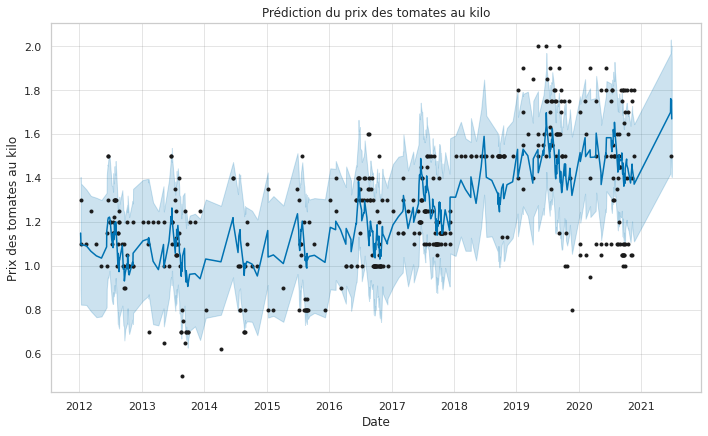

In [9]:
m1.plot(predictions)
plt.title("Prédiction du prix des tomates au kilo")
plt.xlabel("Date")
plt.ylabel("Prix des tomates au kilo")
plt.show()

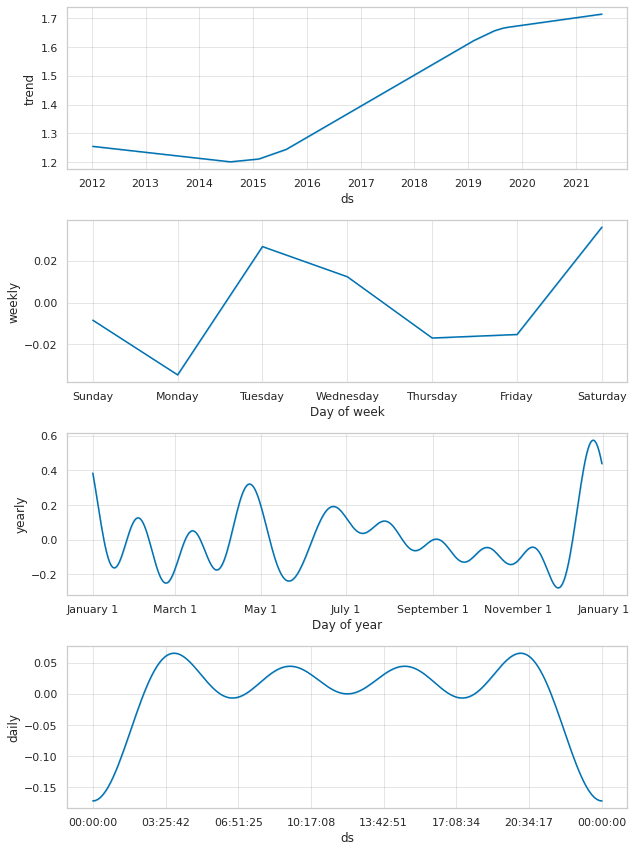

In [10]:
m1.plot_components(predictions)
plt.show()

In [11]:
metric_df = predictions.set_index('ds')[['yhat']].join(dfP.set_index('ds').y).reset_index()
metric_df

,ds,yhat,y
0,2012-01-08,1.148710,1.30
1,2012-01-10,1.095558,1.10
2,2012-02-10,1.091191,1.10
3,2012-03-08,1.065936,1.25
4,2012-04-09,1.044955,1.10
...,...,...,...
426,2021-06-24,1.713677,NaN
427,2021-06-25,1.710776,NaN
428,2021-06-26,1.755827,NaN
429,2021-06-27,1.703743,NaN


In [12]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
419,2020-11-09,1.442833,1.75
420,2020-11-09,1.442833,1.05
421,2020-11-19,1.388861,1.80
422,2020-11-20,1.371404,1.50
423,2021-06-21,1.698838,1.50


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
R2P = r2_score(metric_df.y, metric_df.yhat)
R2P

0.4789513974193961

In [14]:
from math import sqrt

rmseP =sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmseP)

0.20782258502160955


In [15]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.16845722206134373

**Pour la production**

In [16]:
dfPo = Pop[["Date","Production quantité \ntonne(s)"]]
dfPo

,Date,Production quantité \ntonne(s)
354,01/08/12,0.20
333,01/10/12,0.20
332,02/10/12,0.20
353,03/08/12,0.30
342,04/09/12,0.40
...,...,...
388,11/09/20,0.50
19,11/09/20,0.50
373,19/11/20,0.05
372,20/11/20,0.10


In [17]:
dfPo['ds'] = pd.to_datetime(dfPo['Date'])
dfPo['y'] = dfPo['Production quantité \ntonne(s)']
dfPo = dfPo.drop(["Date","Production quantité \ntonne(s)"], axis=1)
dfPo

,ds,y
354,2012-01-08,0.20
333,2012-01-10,0.20
332,2012-02-10,0.20
353,2012-03-08,0.30
342,2012-04-09,0.40
...,...,...
388,2020-11-09,0.50
19,2020-11-09,0.50
373,2020-11-19,0.05
372,2020-11-20,0.10


In [18]:
m2 = Prophet(daily_seasonality=True)
m2.fit(dfPo)

In [19]:
future2 = m2.make_future_dataframe(periods=7, freq='D')
predictions2=m2.predict(future2)

In [20]:
predictions2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.397320,-1.288873,0.545511
401,2021-06-23,-0.133106,-1.026851,0.759159
402,2021-06-24,0.239851,-0.657803,1.071588
403,2021-06-25,-0.073321,-0.964744,0.850743
404,2021-06-26,0.202726,-0.661373,1.089723
405,2021-06-27,-0.049050,-0.880324,0.829898
406,2021-06-28,0.264764,-0.654445,1.097760


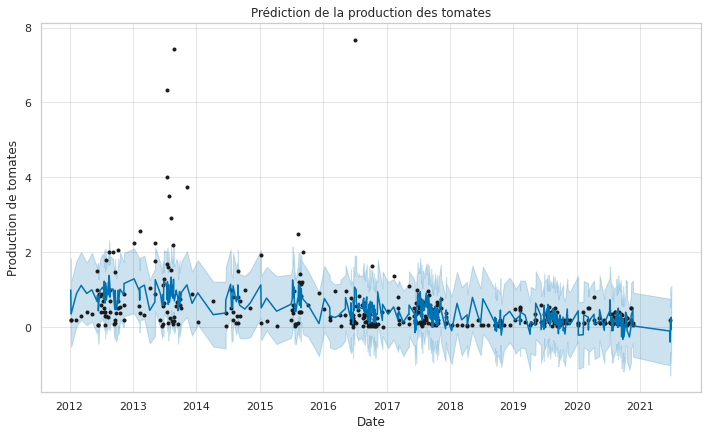

In [21]:
m2.plot(predictions2)
plt.title("Prédiction de la production des tomates")
plt.xlabel("Date")
plt.ylabel("Production de tomates")
plt.show()

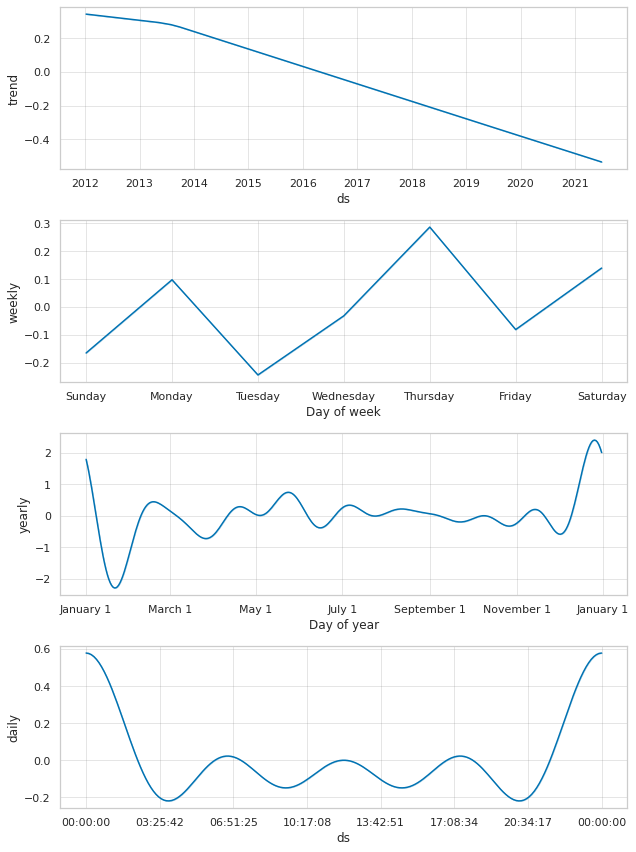

In [22]:
m2.plot_components(predictions2)
plt.show()

In [23]:
metric_df2 = predictions2.set_index('ds')[['yhat']].join(dfPo.set_index('ds').y).reset_index()
metric_df2

,ds,yhat,y
0,2012-01-08,0.995271,0.2
1,2012-01-10,0.352439,0.2
2,2012-02-10,0.893852,0.2
3,2012-03-08,1.117029,0.3
4,2012-04-09,0.901686,0.4
...,...,...,...
426,2021-06-24,0.239851,NaN
427,2021-06-25,-0.073321,NaN
428,2021-06-26,0.202726,NaN
429,2021-06-27,-0.049050,NaN


In [24]:
metric_df2.dropna(inplace=True)
metric_df2.tail()

,ds,yhat,y
419,2020-11-09,0.307811,0.50
420,2020-11-09,0.307811,0.50
421,2020-11-19,0.457489,0.05
422,2020-11-20,0.035453,0.10
423,2021-06-21,-0.102936,0.20


In [25]:
R2Po = r2_score(metric_df2.y, metric_df2.yhat)
R2Po

0.2299113411877357

In [26]:
rmsePo =sqrt(mean_squared_error(metric_df2.y, metric_df2.yhat))
print(rmsePo)

0.6808598285049411


In [27]:
mean_absolute_error(metric_df2.y, metric_df2.yhat)

0.3607581211406575

**Météo future**

In [28]:
#la température minimale

dfTm = Pop[["Date","Température minimale en °C"]]
dfTm

,Date,Température minimale en °C
354,01/08/12,11.8
333,01/10/12,3.5
332,02/10/12,12.8
353,03/08/12,12.0
342,04/09/12,12.8
...,...,...
388,11/09/20,14.1
19,11/09/20,14.1
373,19/11/20,5.8
372,20/11/20,-0.1


In [29]:
dfTm['ds'] = pd.to_datetime(dfTm['Date'])
dfTm['y'] = dfTm['Température minimale en °C']
dfTm = dfTm.drop(["Date","Température minimale en °C"], axis=1)
dfTm

,ds,y
354,2012-01-08,11.8
333,2012-01-10,3.5
332,2012-02-10,12.8
353,2012-03-08,12.0
342,2012-04-09,12.8
...,...,...
388,2020-11-09,14.1
19,2020-11-09,14.1
373,2020-11-19,5.8
372,2020-11-20,-0.1


In [30]:
m3 = Prophet(daily_seasonality=True)
m3.fit(dfTm)

In [31]:
future3 = m3.make_future_dataframe(periods=7, freq='D')
predictions3=m3.predict(future3)

In [32]:
predictions3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,14.523236,9.989993,18.799034
401,2021-06-23,15.556457,10.795546,19.997608
402,2021-06-24,14.459556,10.382378,18.990922
403,2021-06-25,14.773555,10.142158,19.269011
404,2021-06-26,12.883433,8.508797,17.620294
405,2021-06-27,12.839891,8.229826,17.577704
406,2021-06-28,13.268042,9.031051,17.912649


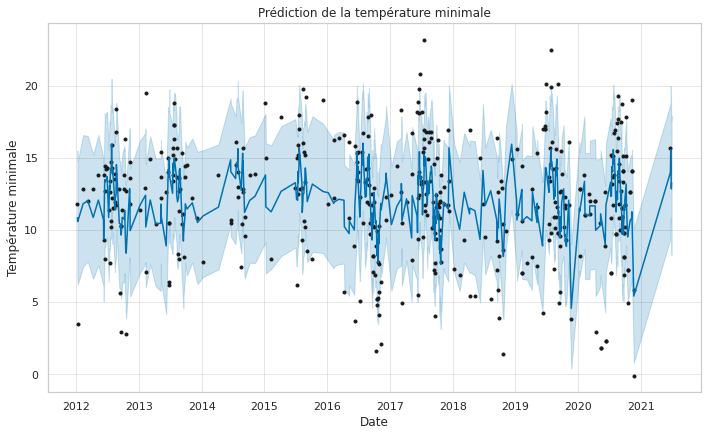

In [33]:
m3.plot(predictions3)
plt.title("Prédiction de la température minimale")
plt.xlabel("Date")
plt.ylabel("Température minimale")
plt.show()

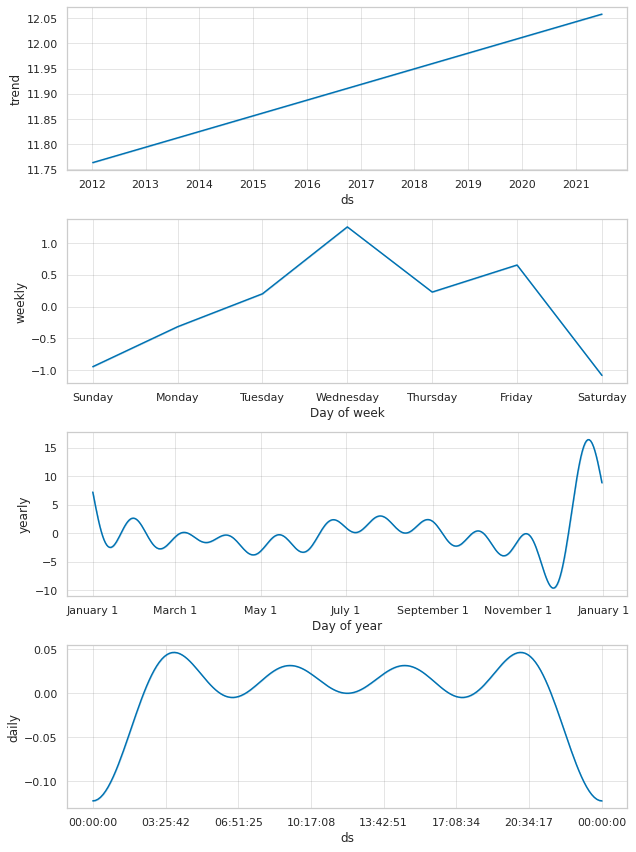

In [34]:
m3.plot_components(predictions3)
plt.show()

In [35]:
#température maximale

dfTM = Pop[["Date","Température maximale en °C"]]
dfTM

,Date,Température maximale en °C
354,01/08/12,28.0
333,01/10/12,19.1
332,02/10/12,18.8
353,03/08/12,24.1
342,04/09/12,25.7
...,...,...
388,11/09/20,28.2
19,11/09/20,28.2
373,19/11/20,11.5
372,20/11/20,10.6


In [36]:
dfTM['ds'] = pd.to_datetime(dfTM['Date'])
dfTM['y'] = dfTM['Température maximale en °C']
dfTM = dfTM.drop(["Date","Température maximale en °C"], axis=1)
dfTM

,ds,y
354,2012-01-08,28.0
333,2012-01-10,19.1
332,2012-02-10,18.8
353,2012-03-08,24.1
342,2012-04-09,25.7
...,...,...
388,2020-11-09,28.2
19,2020-11-09,28.2
373,2020-11-19,11.5
372,2020-11-20,10.6


In [37]:
m4 = Prophet(daily_seasonality=True)
m4.fit(dfTM)

In [38]:
future4 = m4.make_future_dataframe(periods=7, freq='D')
predictions4=m4.predict(future4)

In [39]:
predictions4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,27.750925,21.751009,34.022963
401,2021-06-23,28.496997,22.054344,34.473138
402,2021-06-24,26.349151,20.142309,32.377310
403,2021-06-25,25.467907,19.095010,31.566443
404,2021-06-26,25.891832,19.770596,32.201649
405,2021-06-27,24.446332,18.289421,30.661429
406,2021-06-28,26.284734,19.818799,32.782409


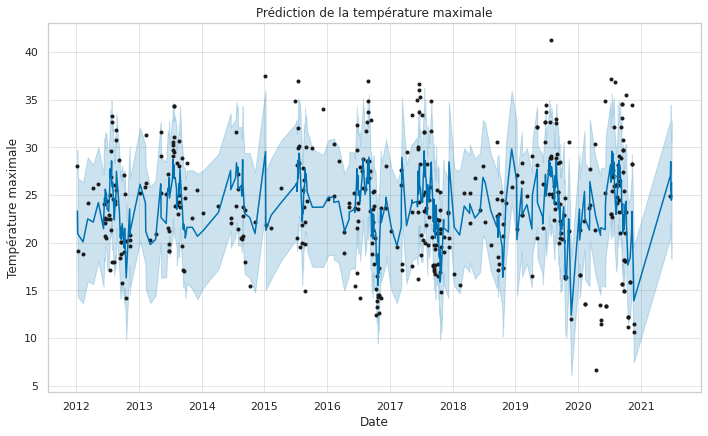

In [40]:
m4.plot(predictions4)
plt.title("Prédiction de la température maximale")
plt.xlabel("Date")
plt.ylabel("Température maximale")
plt.show()

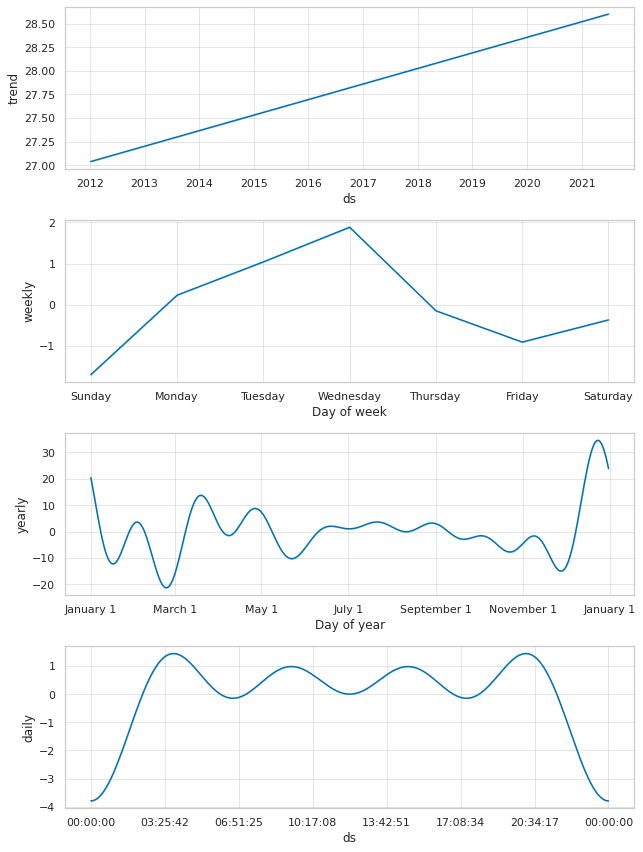

In [41]:
m4.plot_components(predictions4)
plt.show()

In [42]:
# les précipitations

dfp = Pop[["Date","précipitations en mm"]]
dfp

,Date,précipitations en mm
354,01/08/12,0.4
333,01/10/12,0.8
332,02/10/12,0.2
353,03/08/12,0.4
342,04/09/12,0.0
...,...,...
388,11/09/20,0.0
19,11/09/20,0.0
373,19/11/20,0.0
372,20/11/20,0.0


In [43]:
dfp['ds'] = pd.to_datetime(dfp['Date'])
dfp['y'] = dfp['précipitations en mm']
dfp = dfp.drop(["Date","précipitations en mm"], axis=1)
dfp

,ds,y
354,2012-01-08,0.4
333,2012-01-10,0.8
332,2012-02-10,0.2
353,2012-03-08,0.4
342,2012-04-09,0.0
...,...,...
388,2020-11-09,0.0
19,2020-11-09,0.0
373,2020-11-19,0.0
372,2020-11-20,0.0


In [44]:
m5 = Prophet(daily_seasonality=True)
m5.fit(dfp)

future5 = m5.make_future_dataframe(periods=7, freq='D')
predictions5=m5.predict(future5)

predictions5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.742439,-5.975649,4.724613
401,2021-06-23,0.553392,-4.577968,5.939752
402,2021-06-24,0.792668,-4.636596,6.330370
403,2021-06-25,1.725412,-4.034919,6.962363
404,2021-06-26,0.403935,-5.558001,5.856668
405,2021-06-27,0.624862,-4.754132,6.062088
406,2021-06-28,-0.091368,-5.371479,5.310539


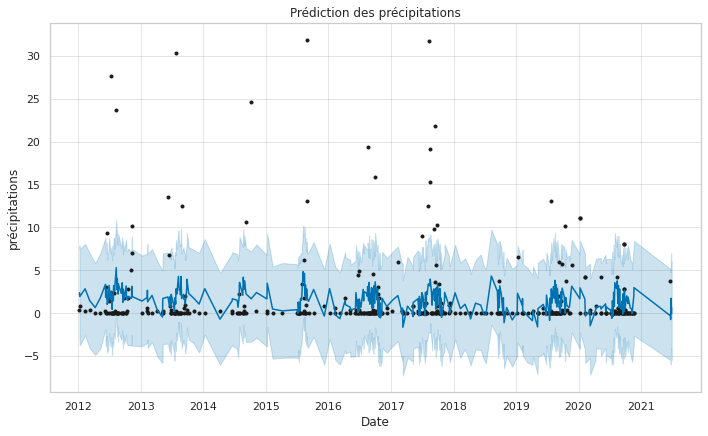

In [45]:
m5.plot(predictions5)
plt.title("Prédiction des précipitations")
plt.xlabel("Date")
plt.ylabel("précipitations")
plt.show()

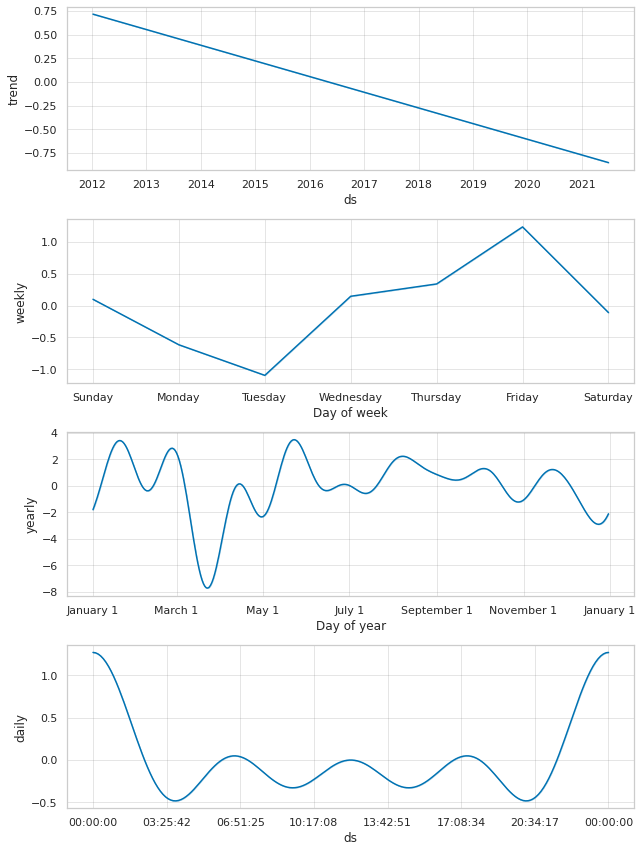

In [46]:
m5.plot_components(predictions5)
plt.show()

In [47]:
#ensoleillement

dfE = Pop[["Date","Ensoleillement en min"]]

dfE['ds'] = pd.to_datetime(dfE['Date'])
dfE['y'] = dfE['Ensoleillement en min']
dfE = dfE.drop(["Date","Ensoleillement en min"], axis=1)
dfE

,ds,y
354,2012-01-08,445
333,2012-01-10,536
332,2012-02-10,121
353,2012-03-08,330
342,2012-04-09,672
...,...,...
388,2020-11-09,552
19,2020-11-09,552
373,2020-11-19,352
372,2020-11-20,297


In [48]:
m6 = Prophet(daily_seasonality=True)
m6.fit(dfE)

future6 = m6.make_future_dataframe(periods=7, freq='D')
predictions6=m6.predict(future6)

predictions6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,578.860623,270.548136,903.811416
401,2021-06-23,577.989268,268.254637,905.249266
402,2021-06-24,519.106653,212.146251,851.837449
403,2021-06-25,483.341494,158.180072,783.349799
404,2021-06-26,607.245217,290.964735,915.924891
405,2021-06-27,439.553676,114.573232,762.523540
406,2021-06-28,526.113999,232.113234,834.855069


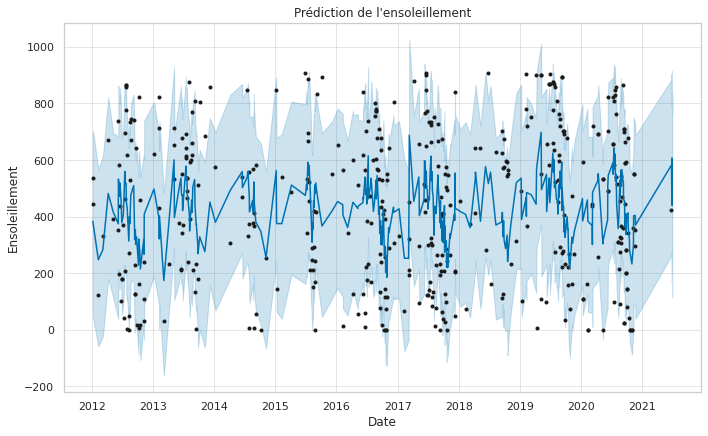

In [49]:
m6.plot(predictions6)
plt.title("Prédiction de l'ensoleillement")
plt.xlabel("Date")
plt.ylabel("Ensoleillement")
plt.show()

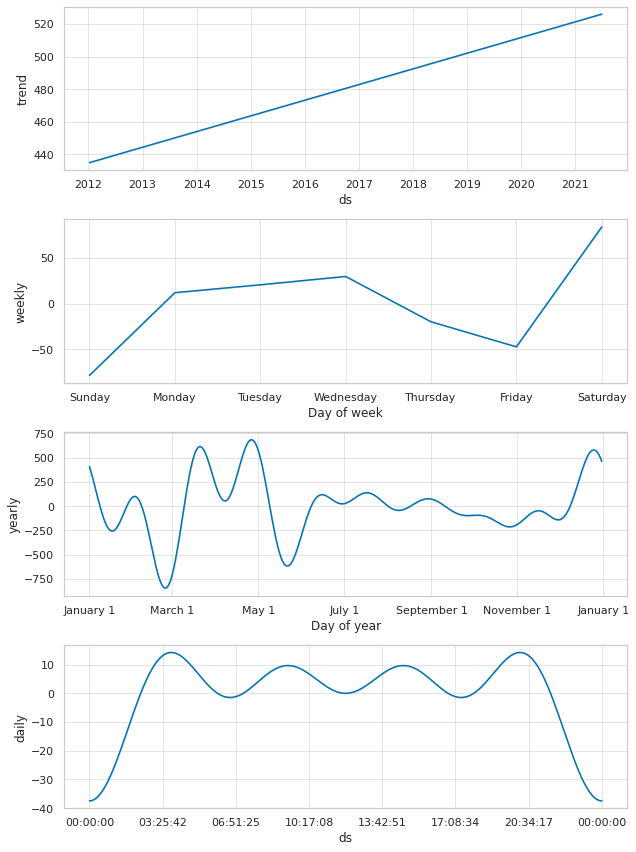

In [50]:
m6.plot_components(predictions6)
plt.show()

In [51]:
#vitesse du vent

dfV = Pop[["Date","Rafales (vitesse du vent) en km/h"]]

dfV['ds'] = pd.to_datetime(dfV['Date'])
dfV['y'] = dfV['Rafales (vitesse du vent) en km/h']
dfV = dfV.drop(["Date","Rafales (vitesse du vent) en km/h"], axis=1)
dfV

,ds,y
354,2012-01-08,44.4
333,2012-01-10,40.7
332,2012-02-10,38.9
353,2012-03-08,42.8
342,2012-04-09,37.0
...,...,...
388,2020-11-09,29.5
19,2020-11-09,29.5
373,2020-11-19,61.2
372,2020-11-20,26.3


In [52]:
m7 = Prophet(daily_seasonality=True)
m7.fit(dfV)

future7 = m7.make_future_dataframe(periods=7, freq='D')
predictions7=m7.predict(future7)

predictions7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,43.888893,29.048296,59.336738
401,2021-06-23,44.795234,31.440251,59.314420
402,2021-06-24,46.019861,30.781492,60.563588
403,2021-06-25,47.267584,33.161025,62.483959
404,2021-06-26,44.372679,29.480576,59.557186
405,2021-06-27,45.936105,31.178814,59.898382
406,2021-06-28,45.511336,29.968479,60.804696


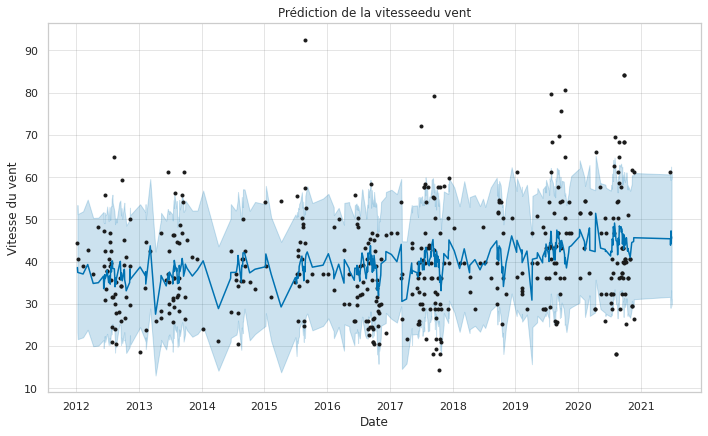

In [53]:
m7.plot(predictions7)
plt.title("Prédiction de la vitesseedu vent")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent")
plt.show()

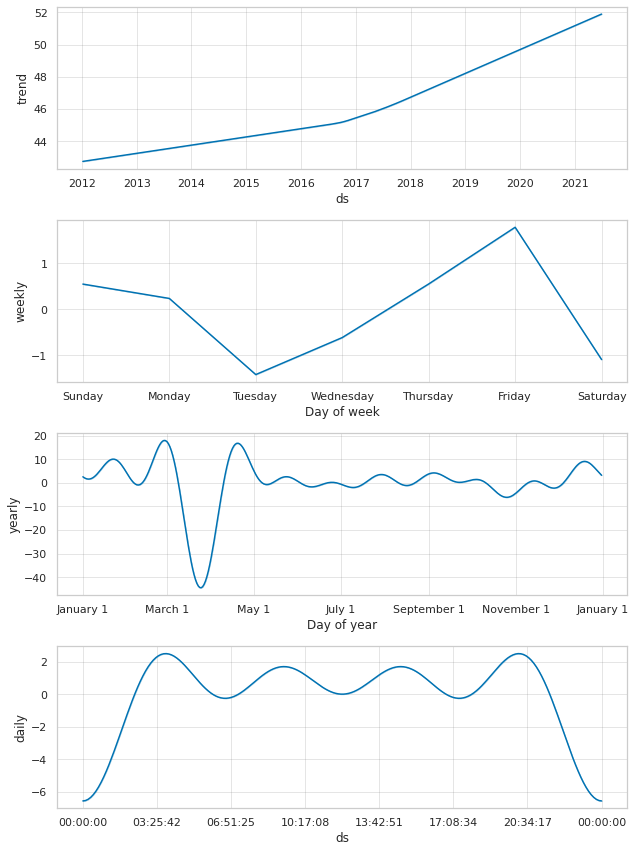

In [54]:
m7.plot_components(predictions7)
plt.show()

**Tableau récapitulatif des prédictions**

In [62]:
RTS={'Prix au kilo des tomates dans 7 jours':[1.761, 1.746, 1.714, 1.711, 1.756, 1.704, 1.668],
     'Production de tomates dans 7 jours' :[0.397, 0.133, 0.240, 0.073, 0.203, 0.049, 0.265],
     'Température minimale dans 7 jours': [14.5, 15.6, 14.5, 14.8, 12.9, 12.8, 13.3],
     'Température maximale dans 7 jours':[27.8, 28.5, 26.3, 25.5, 25.9, 24.4, 26.3],
     'Précipitations dans 7 jours':[0.7, 0.6, 0.8, 1.7, 0.4, 0.6, 0.1],
     'Ensoleillement dans 7 jours':[579, 578, 519, 483, 607, 440, 526],
     'Vitesse du vent dans 7 jours':[43.9, 44.8, 46, 47.3, 44.4, 45.9, 45.5]}
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.761,0.397,14.5,27.8,0.7,579,43.9
2021-06-23,1.746,0.133,15.6,28.5,0.6,578,44.8
2021-06-24,1.714,0.240,14.5,26.3,0.8,519,46.0
2021-06-25,1.711,0.073,14.8,25.5,1.7,483,47.3
2021-06-26,1.756,0.203,12.9,25.9,0.4,607,44.4
2021-06-27,1.704,0.049,12.8,24.4,0.6,440,45.9
2021-06-28,1.668,0.265,13.3,26.3,0.1,526,45.5


**Enregistrement du modèle pour la production**

In [63]:
import pickle

filename = 'modèle_prophet_Production.pkl'
pickle.dump(m2, open(filename, 'wb'))

In [64]:
modèle2 = pickle.load(open(filename, 'rb'))
modèle2